# Reproduce Experiments

This notebook gives the instructions for how to conduct (and reproduce) the experiments in the paper: 

[**The Meta-Evaluation Problem in Explainable AI:
Rethinking Performance Estimation with MetaQuantus**](INSERT_PREPRINT_LINK)

In order to prepare the datasets, please see the separate notebook **Data-Generation-Experiments.ipynb**.

In [1]:
!pip install matplotlib==3.5.1
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install captum>=0.4.1
!pip install quantus>=0.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
# Import libraries.
from IPython.display import clear_output
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum 
import quantus
warnings.filterwarnings("ignore", category=UserWarning)
clear_output()

Customise local paths

In [3]:
# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
PATH_DATA = PATH_ASSETS + "data/"

# FIXME: Replace with pip install.
#!pip install metaquantus
# Import local packages.
import sys
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Mounted at /content/drive


In [4]:
# Experimental settings.
estimators = {"Complexity": ["Sparseness", "Complexity"], 
              "Faithfulness": ["Faithfulness Correlation", "Pixel-Flipping"], 
              "Localisation": ["Pointing-Game", "Relevance Mass Accuracy"], 
              "Randomisation": ["Random Logit", "Model Parameter Randomisation Test"], 
              "Robustness": ["Max-Sensitivity", "Local Lipschitz Estimate"], }

# Plotting settings.
colours_categories = {'Complexity': "brown", 'Faithfulness': "blue", 'Localisation': "orange", 'Randomisation': "green", 'Robustness': "red"}
colours = {'Sparseness': "#411900",
 'Complexity': "#7f4e1e",
 'Faithfulness Correlation': "#00555a",
 'Pixel-Flipping': "cadetblue",
 'Pointing-Game': "chocolate",
 'Relevance Mass Accuracy': "peru",
 'Random Logit': "darkolivegreen",
 'Model Parameter Randomisation Test': "darkseagreen",
 'Max-Sensitivity': "darkred",
 'Local Lipschitz Estimate': "indianred",}
 
plt.style.use(['seaborn-white'])

## 1) Benchmarking Estimators

As a first experiment, we show how to benchmark estimators.

In [5]:
from metaquantus import load_obj, make_benchmarking_df_as_str
from metaquantus import plot_multiple_estimator_area, plot_single_estimator_area, plot_benchmarking_scatter_bar_plots_combined, plot_benchmarking_scatter_plots, plot_top_ranking_distribution
from metaquantus import make_benchmarking_df_as_str, make_benchmarking_df, aggregate_benchmarking_datasets, compute_means_over_datasets, compute_ranking_over_datasets

#### 1.1 Load data

As a starter, you need to either load or generate the results. This is done by running the python scripts as listed below. Ensure to have GPUs enabled at this stage as this will speed up computation considerably. Feel free to change the hyperparameters if you want to run similar experiments on other explanation methods, datasets or models. The results are then analysed and visualisations are created below.

```bash
python3 run_benchmarking.py --dataset=MNIST --fname=f --K=5 --iters=3
python3 run_benchmarking.py --dataset=fMNIST --fname=f --K=5 --iters=3
python3 run_benchmarking.py --dataset=cMNIST --fname=f --K=5 --iters=3
```

In [6]:
# Load the benchmarking data for each dataset.
dataset_name = "MNIST"
benchmark_mnist = load_obj(PATH_DATA, fname=f"benchmark_MNIST", use_json=True)[dataset_name]["LeNet"]

dataset_name = "fMNIST"
benchmark_fmnist = load_obj(PATH_DATA, fname=f"benchmark_fMNIST", use_json=True)[dataset_name]["LeNet"]

dataset_name = "cMNIST"
benchmark_cmnist = load_obj(PATH_DATA, fname=f"benchmark_cMNIST", use_json=True)[dataset_name]["ResNet9"]

In [7]:
# Create table from benchmarking MNSIT data.
df_mnist = make_benchmarking_df_as_str(benchmark=benchmark_mnist, estimators=estimators)
df_mnist

,Category,Estimator,Test,MC_bar,MC,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR}
0,Complexity,Sparseness,Model,,0.640 $\pm$ 0.043,0.209 $\pm$ 0.040,0.946 $\pm$ 0.086,0.837 $\pm$ 0.002,0.569 $\pm$ 0.046
1,Complexity,Sparseness,Input,0.558 $\pm$ 0.028,0.476 $\pm$ 0.013,0.929 $\pm$ 0.063,0.053 $\pm$ 0.014,0.840 $\pm$ 0.005,0.084 $\pm$ 0.001
2,Complexity,Complexity,Model,,0.541 $\pm$ 0.007,0.009 $\pm$ 0.013,1.000 $\pm$ 0.000,1.000 $\pm$ 0.000,0.156 $\pm$ 0.014
4,Complexity,Complexity,Input,0.521 $\pm$ 0.003,0.500 $\pm$ 0.000,0.167 $\pm$ 0.000,0.833 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000
5,Faithfulness,Faithfulness Correlation,Model,,0.537 $\pm$ 0.003,0.477 $\pm$ 0.032,0.900 $\pm$ 0.023,0.190 $\pm$ 0.003,0.579 $\pm$ 0.008
7,Faithfulness,Faithfulness Correlation,Input,0.540 $\pm$ 0.015,0.543 $\pm$ 0.026,0.500 $\pm$ 0.107,0.890 $\pm$ 0.005,0.190 $\pm$ 0.002,0.594 $\pm$ 0.005
9,Faithfulness,Pixel-Flipping,Model,,0.609 $\pm$ 0.039,0.547 $\pm$ 0.139,0.963 $\pm$ 0.034,0.299 $\pm$ 0.001,0.626 $\pm$ 0.046
12,Faithfulness,Pixel-Flipping,Input,0.626 $\pm$ 0.039,0.644 $\pm$ 0.038,0.485 $\pm$ 0.141,1.000 $\pm$ 0.000,0.294 $\pm$ 0.006,0.796 $\pm$ 0.006
14,Localisation,Pointing-Game,Model,,0.672 $\pm$ 0.020,0.977 $\pm$ 0.005,0.607 $\pm$ 0.075,0.996 $\pm$ 0.000,0.108 $\pm$ 0.012
17,Localisation,Pointing-Game,Input,0.586 $\pm$ 0.010,0.500 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000


In [8]:
# Create table from benchmarking fMNSIT data.
df_fmnist = make_benchmarking_df_as_str(benchmark=benchmark_fmnist, estimators=estimators)
df_fmnist

,Category,Estimator,Test,MC_bar,MC,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR}
0,Complexity,Sparseness,Model,,0.596 $\pm$ 0.012,0.145 $\pm$ 0.039,0.915 $\pm$ 0.045,0.831 $\pm$ 0.004,0.492 $\pm$ 0.082
1,Complexity,Sparseness,Input,0.536 $\pm$ 0.011,0.475 $\pm$ 0.010,0.917 $\pm$ 0.036,0.070 $\pm$ 0.003,0.832 $\pm$ 0.003,0.083 $\pm$ 0.001
2,Complexity,Complexity,Model,,0.532 $\pm$ 0.014,0.050 $\pm$ 0.047,0.990 $\pm$ 0.027,0.999 $\pm$ 0.000,0.086 $\pm$ 0.028
4,Complexity,Complexity,Input,0.516 $\pm$ 0.007,0.500 $\pm$ 0.000,0.167 $\pm$ 0.000,0.833 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000
5,Faithfulness,Faithfulness Correlation,Model,,0.524 $\pm$ 0.021,0.527 $\pm$ 0.030,0.857 $\pm$ 0.072,0.198 $\pm$ 0.008,0.515 $\pm$ 0.004
7,Faithfulness,Faithfulness Correlation,Input,0.530 $\pm$ 0.021,0.536 $\pm$ 0.021,0.448 $\pm$ 0.087,0.994 $\pm$ 0.003,0.196 $\pm$ 0.004,0.504 $\pm$ 0.002
9,Faithfulness,Pixel-Flipping,Model,,0.573 $\pm$ 0.025,0.447 $\pm$ 0.050,0.958 $\pm$ 0.088,0.329 $\pm$ 0.002,0.558 $\pm$ 0.032
12,Faithfulness,Pixel-Flipping,Input,0.611 $\pm$ 0.021,0.649 $\pm$ 0.018,0.453 $\pm$ 0.073,1.000 $\pm$ 0.000,0.324 $\pm$ 0.001,0.817 $\pm$ 0.003
14,Localisation,Pointing-Game,Model,,0.666 $\pm$ 0.009,0.950 $\pm$ 0.025,0.634 $\pm$ 0.032,0.995 $\pm$ 0.001,0.084 $\pm$ 0.018
17,Localisation,Pointing-Game,Input,0.583 $\pm$ 0.005,0.500 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000


In [9]:
# Create table from benchmarking cMNSIT data.
df_cmnist = make_benchmarking_df_as_str(benchmark=benchmark_cmnist, estimators=estimators)
df_cmnist

,Category,Estimator,Test,MC_bar,MC,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR}
0,Complexity,Sparseness,Model,,0.706 $\pm$ 0.013,0.352 $\pm$ 0.061,0.989 $\pm$ 0.017,0.814 $\pm$ 0.001,0.670 $\pm$ 0.016
1,Complexity,Sparseness,Input,0.616 $\pm$ 0.015,0.525 $\pm$ 0.018,0.626 $\pm$ 0.099,0.313 $\pm$ 0.028,0.830 $\pm$ 0.005,0.333 $\pm$ 0.006
2,Complexity,Complexity,Model,,0.565 $\pm$ 0.024,0.056 $\pm$ 0.084,1.000 $\pm$ 0.000,0.996 $\pm$ 0.001,0.209 $\pm$ 0.013
4,Complexity,Complexity,Input,0.541 $\pm$ 0.018,0.518 $\pm$ 0.013,0.062 $\pm$ 0.010,0.928 $\pm$ 0.047,1.000 $\pm$ 0.000,0.080 $\pm$ 0.005
5,Faithfulness,Faithfulness Correlation,Model,,0.563 $\pm$ 0.017,0.508 $\pm$ 0.061,0.939 $\pm$ 0.017,0.182 $\pm$ 0.004,0.622 $\pm$ 0.005
7,Faithfulness,Faithfulness Correlation,Input,0.562 $\pm$ 0.014,0.562 $\pm$ 0.010,0.490 $\pm$ 0.031,0.934 $\pm$ 0.018,0.188 $\pm$ 0.008,0.634 $\pm$ 0.012
9,Faithfulness,Pixel-Flipping,Model,,0.586 $\pm$ 0.022,0.565 $\pm$ 0.040,0.965 $\pm$ 0.022,0.287 $\pm$ 0.005,0.526 $\pm$ 0.080
12,Faithfulness,Pixel-Flipping,Input,0.604 $\pm$ 0.016,0.621 $\pm$ 0.010,0.495 $\pm$ 0.037,0.995 $\pm$ 0.001,0.295 $\pm$ 0.012,0.701 $\pm$ 0.002
14,Localisation,Pointing-Game,Model,,0.873 $\pm$ 0.010,0.967 $\pm$ 0.000,1.000 $\pm$ 0.000,0.997 $\pm$ 0.000,0.527 $\pm$ 0.040
17,Localisation,Pointing-Game,Input,0.687 $\pm$ 0.006,0.502 $\pm$ 0.001,0.995 $\pm$ 0.003,0.013 $\pm$ 0.003,0.999 $\pm$ 0.001,0.001 $\pm$ 0.000


In [10]:
df_cmnist.to_latex()

'\\begin{tabular}{llllllllll}\n\\toprule\n{} &       Category &                           Estimator &   Test &             MC\\_bar &                 MC &           IAC\\_\\{NR\\} &           IAC\\_\\{AR\\} &           IEC\\_\\{NR\\} &           IEC\\_\\{AR\\} \\\\\n\\midrule\n0  &     Complexity &                          Sparseness &  Model &                    &  0.706 \\$\\textbackslash pm\\$ 0.013 &  0.352 \\$\\textbackslash pm\\$ 0.061 &  0.989 \\$\\textbackslash pm\\$ 0.017 &  0.814 \\$\\textbackslash pm\\$ 0.001 &  0.670 \\$\\textbackslash pm\\$ 0.016 \\\\\n1  &     Complexity &                          Sparseness &  Input &  0.616 \\$\\textbackslash pm\\$ 0.015 &  0.525 \\$\\textbackslash pm\\$ 0.018 &  0.626 \\$\\textbackslash pm\\$ 0.099 &  0.313 \\$\\textbackslash pm\\$ 0.028 &  0.830 \\$\\textbackslash pm\\$ 0.005 &  0.333 \\$\\textbackslash pm\\$ 0.006 \\\\\n2  &     Complexity &                          Complexity &  Model &                    &  0.565 \\$\\textbackslash

In [11]:
# To fill the tables.
#df_mnist[["IAC_{NR}", "IAC_{AR}",	"IEC_{NR}",	"IEC_{AR}",	"MC"]].to_latex()
#df_fmnist[["IAC_{NR}", "IAC_{AR}",	"IEC_{NR}",	"IEC_{AR}",	"MC"]].to_latex()
#df_cmnist[["IAC_{NR}", "IAC_{AR}",	"IEC_{NR}",	"IEC_{AR}",	"MC"]].to_latex()

### 1.2 Analyse results

When the results data is loaded, we analyse and create visualisations as described in the following.

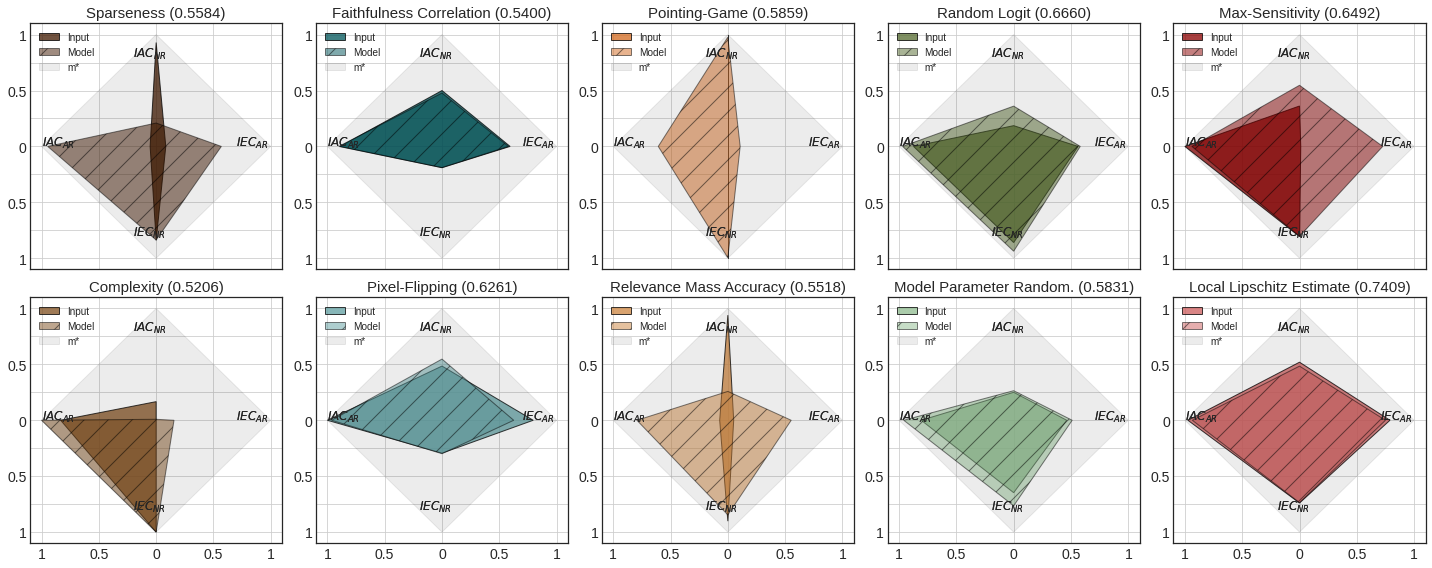

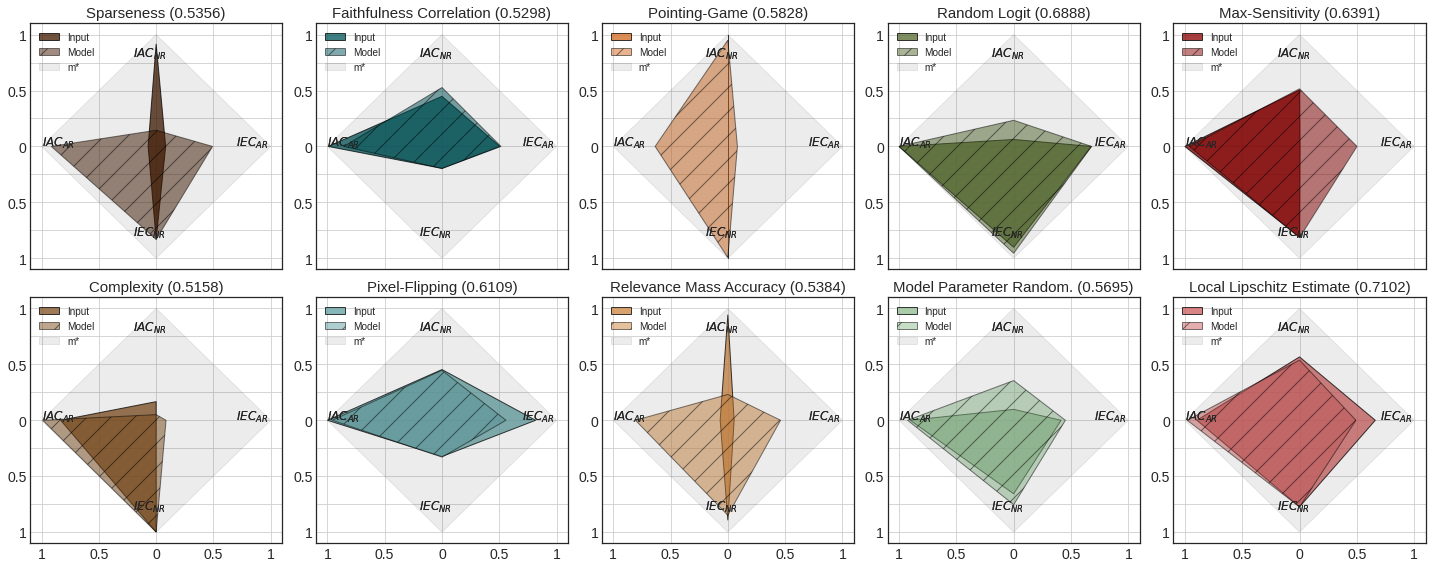

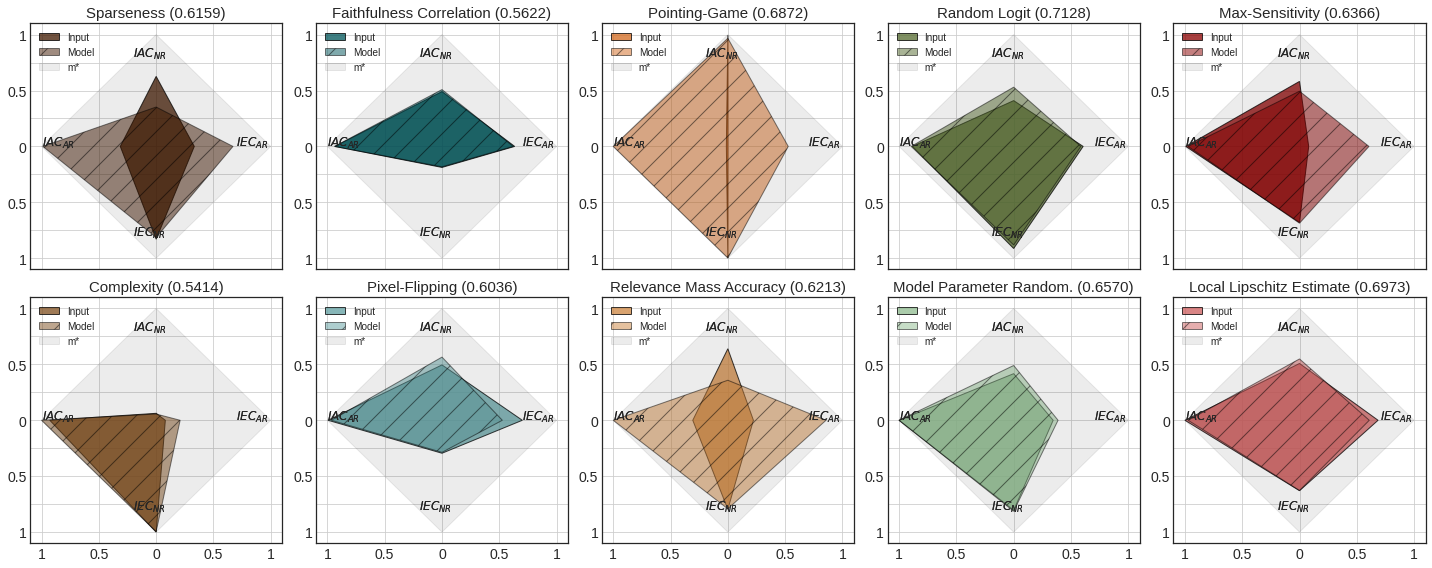

In [12]:
# Plot the benchmarking results!
plot_multiple_estimator_area(benchmark=benchmark_mnist, estimators=estimators, dataset_name="MNIST", colours=colours, save=True, path=PATH_ASSETS);
plot_multiple_estimator_area(benchmark=benchmark_fmnist, estimators=estimators, dataset_name="fMNIST", colours=colours, save=True, path=PATH_ASSETS);
plot_multiple_estimator_area(benchmark=benchmark_cmnist, estimators=estimators, dataset_name="cMNIST", colours=colours, save=True, path=PATH_ASSETS);

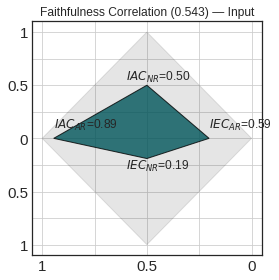

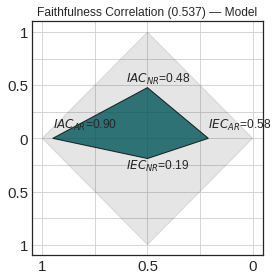

In [13]:
# Plot single estimator areas.
plot_single_estimator_area(benchmark=benchmark_mnist, estimator_category="Faithfulness", estimator_name="Faithfulness Correlation", dataset_name="MNIST", perturbation_type="Input", colours=colours, save=True, path=PATH_ASSETS);
plot_single_estimator_area(benchmark=benchmark_mnist, estimator_category="Faithfulness", estimator_name="Faithfulness Correlation", dataset_name="MNIST", perturbation_type="Model", colours=colours, save=True, path=PATH_ASSETS);

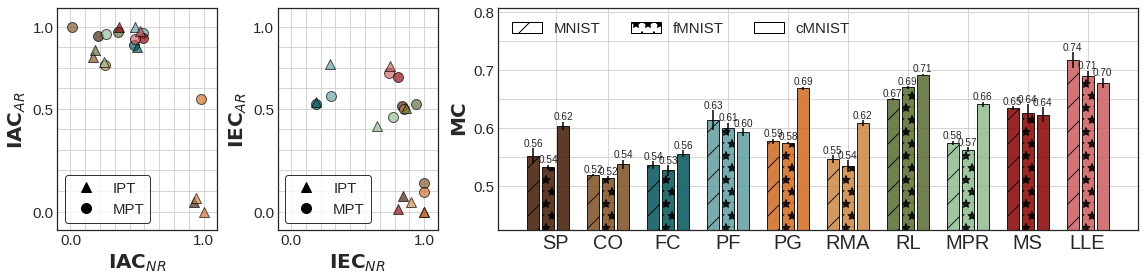

In [14]:
# Prepare data.
df_mnist = make_benchmarking_df(benchmark=benchmark_mnist, estimators=estimators)
means, stds = aggregate_benchmarking_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Model", "Input"])

# Plot benchmarking scatter plots, combined.
plot_benchmarking_scatter_bar_plots_combined(df=df_mnist, means=means, stds=stds, colours=colours, save=True, path=PATH_ASSETS);

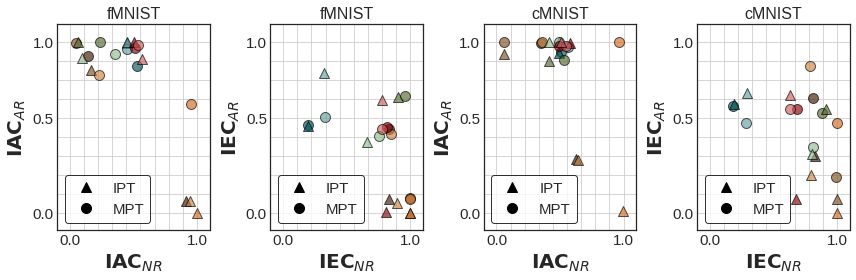

In [15]:
# Plot the extra scatter plots for fMNIST and cMNIST.
dfs = {"fMNIST": make_benchmarking_df(benchmark=benchmark_fmnist, estimators=estimators),
       "cMNIST": make_benchmarking_df(benchmark=benchmark_cmnist, estimators=estimators)}
plot_benchmarking_scatter_plots(dfs=dfs, colours=colours, save=True, path=PATH_ASSETS);

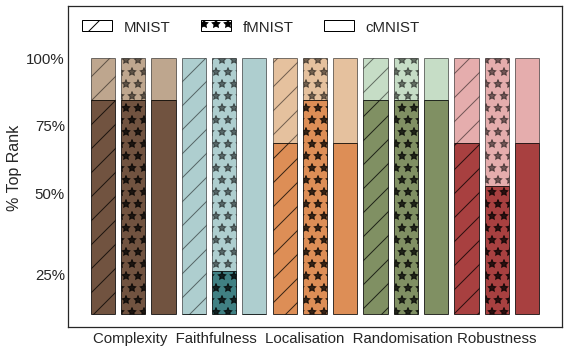

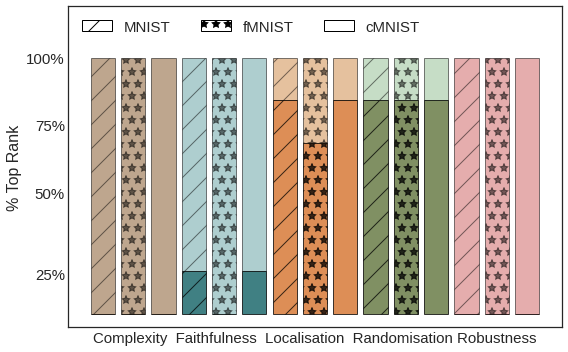

In [16]:
# We also visualise the ranking consistency for the "winning" estimator in each category.

# Prepare data.
means_mnist, means_fmnist, means_cmnist = compute_means_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Model"], include_std=True)
ranking, frac_1st_estimator_1st, frac_2nd_estimator_1st = compute_ranking_over_datasets(means_mnist, means_fmnist, means_cmnist, estimators, perturbation_types=["Model"])

# Plot the ranking distribution.
plot_top_ranking_distribution(frac_1st_estimator_1st=frac_1st_estimator_1st, frac_2nd_estimator_1st=frac_2nd_estimator_1st, estimators=estimators, colours=colours, dataset_name="ALL_Model", path=PATH_ASSETS, save=True)

# We also do this for IPT test.
means_mnist, means_fmnist, means_cmnist = compute_means_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Input"], include_std=True)
ranking, frac_1st_estimator_1st, frac_2nd_estimator_1st = compute_ranking_over_datasets(means_mnist, means_fmnist, means_cmnist, estimators, perturbation_types=["Input"])

# Plot the ranking distribution.
plot_top_ranking_distribution(frac_1st_estimator_1st=frac_1st_estimator_1st, frac_2nd_estimator_1st=frac_2nd_estimator_1st, estimators=estimators, colours=colours, dataset_name="ALL_Input", path=PATH_ASSETS, save=True)

## 2) Hyperparameter Optimisation


As a third experiment, we show how to use the MC score as a target variable for hyperparameter optimisation of a metric.

To gather data, run hp experiment as follows:
```bash
python3 run_hp.py --dataset=ImageNet --K=3 --iters=2
```

In [17]:
from metaquantus import plot_hp_bar

#### 2.1 Load data

We use the benchmarking data for this purpose (already loaded in Section 1).

In [18]:
# Load the data from the hyperparameter exercise on ImageNet.
df_result = pd.read_csv(PATH_DATA+"hp_optimisation_ImageNet.csv")
df_result["Setting"] = np.arange(1, len(df_result)+1)
df_result.head()

,Unnamed: 0,Test,MC Mean,MC Std,Baseline Strategy,Subset Size,IAC_{NR} mean,IAC_{NR} std,IAC_{AR} mean,IAC_{AR} std,IEC_{NR} mean,IEC_{NR} std,IEC_{AR} mean,IEC_{AR} std,Setting
0,0,MPT,0.484862,0.016631,Black,28,0.476953,0.016878,0.719994,0.016878,0.268889,0.000556,0.473611,0.006389,1
1,1,MPT,0.502864,0.033075,Black,52,0.615000,0.118897,0.657416,0.118897,0.253333,0.016111,0.485709,0.000958,2
2,2,MPT,0.507748,0.007712,Black,102,0.441871,0.005466,0.830232,0.005466,0.258056,0.005833,0.500833,0.004722,3
3,3,MPT,0.534052,0.016083,Black,128,0.529893,0.030154,0.820168,0.030154,0.257537,0.004685,0.528611,0.018056,4
4,4,MPT,0.467436,0.001580,Uniform,28,0.474480,0.058386,0.640991,0.058386,0.268719,0.018194,0.485556,0.003333,5


In [19]:
# Showcase the best parameter setting.
df_result.loc[df_result["MC Mean"].argmax()]

Unnamed: 0                 10
Test                      MPT
MC Mean              0.540099
MC Std               0.007526
Baseline Strategy        Mean
Subset Size               102
IAC_{NR} mean        0.563655
IAC_{NR} std         0.035652
IAC_{AR} mean        0.826751
IAC_{AR} std         0.035652
IEC_{NR} mean        0.251378
IEC_{NR} std         0.003048
IEC_{AR} mean        0.518611
IEC_{AR} std           0.0075
Setting                    11
Name: 10, dtype: object

### 2.1 Analyse results

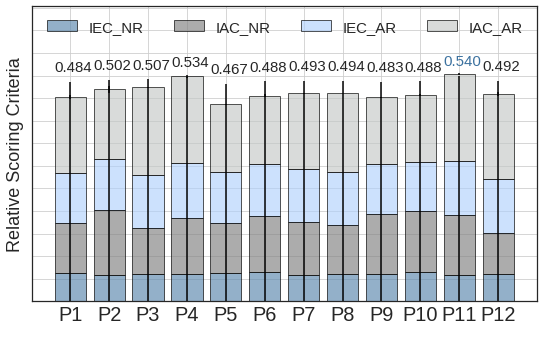

In [20]:
plot_hp_bar(df_result=df_result, dataset_name="ImageNet", save=True, path=PATH_ASSETS)

## 3) Category Convergence

As a third experiment, we show how to measure if the different metrics of the same cateory are measuring the same concept, aka is there convergence within the category?

#### 3.1 Load data

We use the benchmarking data for this purpose (already loaded in Section 1).

In [21]:
from metaquantus import make_category_convergence_df, plot_category_convergence

In [22]:
# Load one of the benchmark to do the analysis on.
df_category_mnist = make_category_convergence_df(benchmark=benchmark_mnist, estimators=estimators)

# Inspect the mean "Within-Category".'
df_category_mnist.groupby(["Within-Category"]).mean()

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Spear. Corr
Within-Category,
0,0.371746
1,0.503747


In [23]:
# Inspect the mean "Within-Category", but over failure modes.
df_category_mnist.groupby(["Within-Category", "Failure Mode"]).mean()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


Spear. Corr
Within-Category Failure Mode             
0               AR               0.310404
                NR               0.424270
1               AR               0.476502
                NR               0.525543

In [24]:
# Load some more datasets.
df_category_fmnist = make_category_convergence_df(benchmark=benchmark_fmnist, estimators=estimators)
df_category_cmnist = make_category_convergence_df(benchmark=benchmark_cmnist, estimators=estimators)

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


### 3.1 Analyse results

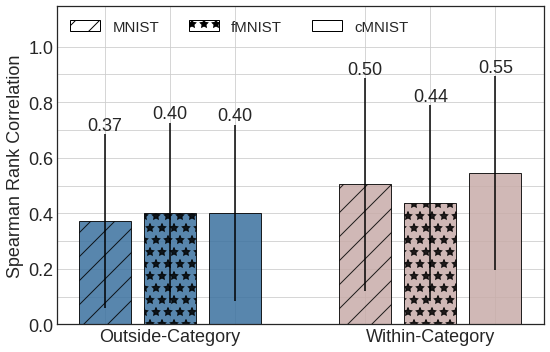

In [25]:
def get_means(df: pd.DataFrame, measure: str = "Spear. Corr"):
    return df.groupby(["Within-Category"])[measure].mean().values

def get_stds(df: pd.DataFrame, measure: str = "Spear. Corr"):
    return df.groupby(["Within-Category"])[measure].std().values 

# Prepare the data!
means = np.array([get_means(df=df_category_mnist)[0], get_means(df=df_category_fmnist)[0], get_means(df=df_category_cmnist)[0],
                  get_means(df=df_category_mnist)[1], get_means(df=df_category_fmnist)[1], get_means(df=df_category_cmnist)[1]]).flatten()
stds = np.array([get_stds(df=df_category_mnist)[0], get_stds(df=df_category_fmnist)[0], get_stds(df=df_category_cmnist)[0],
                 get_stds(df=df_category_mnist)[1], get_stds(df=df_category_fmnist)[1], get_stds(df=df_category_cmnist)[1]]).flatten()

# Plot it!
plot_category_convergence(means, stds, save=False, path=PATH_ASSETS)

## 4) Faithfulness Ranking Disagreement


As a forth experiment, we showcase how different rankings can be achieved by different estimators.

To gather data, run faithfulness ranking experiment as follows:
```bash
python3 run_ranking.py --dataset=cMNIST --fname=f --K=5 --iters=3 --category=Faithfulness
```

In [26]:
from metaquantus import load_obj, make_benchmarking_df
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

#### 4.1 Load data

We use ranking and benchmarking data for this purpose (already loaded in Section 1)



In [27]:
# Load the ranking data.
df_ranking = pd.read_csv(PATH_DATA+"faithfulness_ranking_cMNIST.csv", index_col=0)
df_ranking

,Estimator,Method,Faithfulness Score,Rank
0,Faithfulness Correlation,IntegratedGradients,0.175225,1.0
1,Faithfulness Correlation,Gradient,0.000894,3.0
2,Faithfulness Correlation,GradCAM,0.150308,2.0
3,Pixel-Flipping,IntegratedGradients,3.433365,2.0
4,Pixel-Flipping,Gradient,2.854514,1.0
5,Pixel-Flipping,GradCAM,5.121380,3.0


In [28]:
dataset_name = "cMNIST"
benchmark_cmnist = load_obj(PATH_DATA, fname=f"benchmark_cMNIST", use_json=True)[dataset_name]["ResNet9"]

In [29]:
# Load the benchmarking data.
df_cmnist_summary = make_benchmarking_df(benchmark=benchmark_cmnist, estimators=estimators)
df_cmnist_summary.groupby("Estimator")["MC"].mean()

Estimator
Complexity                            0.541432
Faithfulness Correlation              0.562218
Local Lipschitz Estimate              0.697328
Max-Sensitivity                       0.636614
Model Parameter Randomisation Test    0.656981
Pixel-Flipping                        0.603588
Pointing-Game                         0.687238
Random Logit                          0.712835
Relevance Mass Accuracy               0.621310
Sparseness                            0.615859
Name: MC, dtype: float64

An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.
An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.


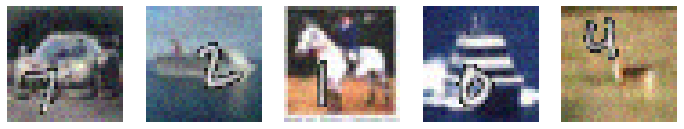

In [33]:
dataset_name = "cMNIST"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

model = dataset_settings[dataset_name]["models"]["ResNet9"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Get explanation methods.
xai_setting = ["IntegratedGradients", "Gradient", "LayerGradCam"]
xai_methods = setup_xai_settings(
    xai_settings=xai_setting,
    gc_layer=dataset_settings[dataset_name]["gc_layers"][model_name],
    img_size=dataset_kwargs["img_size"],
    nr_channels=dataset_kwargs["nr_channels"],
)

# Get estimators.
estimators = setup_estimators(
    features=dataset_kwargs["features"],
    num_classes=dataset_kwargs["num_classes"],
    img_size=dataset_kwargs["img_size"],
    percentage=dataset_kwargs["percentage"],
    patch_size=dataset_kwargs["patch_size"],
    perturb_baseline=dataset_kwargs["perturb_baseline"],
)

# Generate explanations.
explanations = {}
for method, kwargs in xai_methods.items():
    model = dataset_settings[dataset_name]["models"]["ResNet9"].eval().cpu()
    explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(32,32, 3))
    ax[i].axis("off")
plt.show()

### 4.1 Analyse results

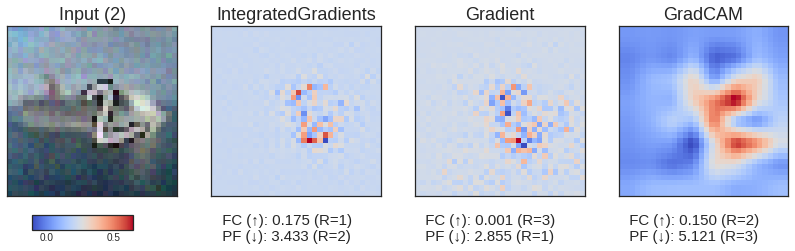

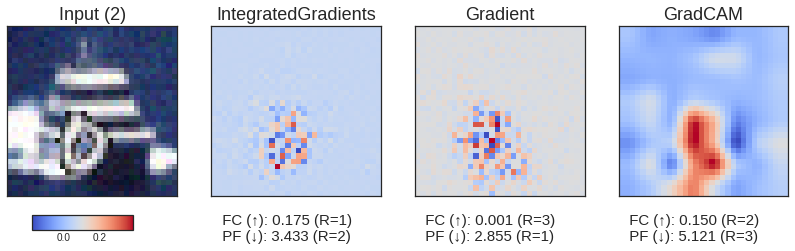

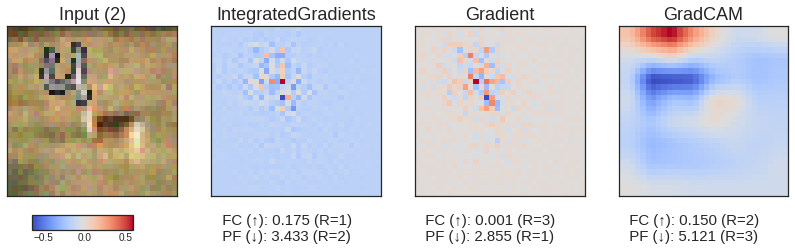

In [34]:
def plot_ranking(save: bool = False):
    # Re-produce plot!
    for index in [1,3,4]:

        fig, ax = plt.subplots(1, 1+len(explanations), figsize=(14, 4))
        for i, (method, values) in enumerate(explanations.items()): 

            # Fixes wtr Quantus version.
            if method == "LayerGradCam": 
                method = "GradCAM"
            fc = float(df_ranking.loc[(df_ranking["Method"]==method) & (df_ranking["Estimator"]=="Faithfulness Correlation"), "Faithfulness Score"].values[0]) 
            fc_rank = int(df_ranking.loc[(df_ranking["Method"]==method) & (df_ranking["Estimator"]=="Faithfulness Correlation"), "Rank"].values[0])
            pf = float(df_ranking.loc[(df_ranking["Method"]==method) & (df_ranking["Estimator"]=="Pixel-Flipping"), "Faithfulness Score"].values[0]) 
            pf_rank = int(df_ranking.loc[(df_ranking["Method"]==method) & (df_ranking["Estimator"]=="Pixel-Flipping"), "Rank"].values[0])
            text = f"  FC (↑): {fc:.3f} (R={fc_rank})\n  PF (↓): {pf:.3f} (R={pf_rank})"
            
            ax[i+1].set_xticks([], [])
            ax[i+1].set_yticks([], [])
            ax[i+1].set_title(method, fontsize=18)
            
            # Fixes wtr Quantus version.
            if method == "GradCAM": 
                method = "LayerGradCam"
            axis = ax[i+1].imshow((explanations[method][index].reshape(32,32)), cmap="coolwarm")
            ax[i+1].text(0, 40, text, fontsize=15)
            
        ax[0].imshow(np.moveaxis(x_batch[index], 0, -1).reshape(32,32, 3))
        ax[0].set_xticks([], [])
        ax[0].set_yticks([], [])
        ax[0].set_title("Input (2)", fontsize=18)

        cax = fig.add_axes([0.15, 0.09, 0.1, 0.05]) # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
        fig.colorbar(axis, cax=cax, orientation='horizontal')
        if save:
            plt.savefig(PATH_DATA+"plots/"+f"motivating_example_{dataset_name}_{index}.png", dpi=1000)
        plt.show()

plot_ranking()